In [640]:
import pandas as pd 
from sklearn.model_selection import GroupKFold
from lightgbm import LGBMClassifier
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', 200)

In [1386]:
path = '/Users/macintosh/Desktop/data_completitions/Kaggle/2023/icr-identify-age-related-conditions'
df_greeks = pd.read_csv(path+'/greeks.csv')
df_sample_sub = pd.read_csv(path+'/sample_submission.csv')
df_test = pd.read_csv(path+'/test.csv')
df_train = pd.read_csv(path+'/train.csv')

In [1387]:
df_greeks.columns = df_greeks.columns.str.lower().str.replace(' ', '')
df_sample_sub.columns = df_sample_sub.columns.str.lower().str.replace(' ', '')
df_test.columns = df_test.columns.str.lower().str.replace(' ', '')
df_train.columns = df_train.columns.str.lower().str.replace(' ', '')

In [1388]:
merge_df = df_train.merge(df_greeks, how='left', left_on='id', right_on='id')

In [1389]:
merge_df.head()

,id,ab,af,ah,am,ar,ax,ay,az,bc,bd,bn,bp,bq,br,bz,cb,cc,cd,cf,ch,cl,cr,cs,cu,cw,da,de,df,dh,di,dl,dn,du,dv,dy,eb,ee,eg,eh,ej,el,ep,eu,fc,fd,fe,fi,fl,fr,fs,gb,ge,gf,gh,gi,gl,class,alpha,beta,gamma,delta,epsilon
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,B,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,B,C,G,D,3/19/2019
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,A,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,A,C,M,B,Unknown
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,B,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,A,C,M,B,Unknown
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,B,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,A,C,M,B,Unknown
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,B,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,D,B,F,B,3/25/2020


In [1390]:
# New features
# Alpha A, B, D, G
feature_alpha_df = pd.get_dummies(merge_df['alpha'])
SELECTED_BETA = ['A', 'B', 'D', 'G']
feature_alpha_df = feature_alpha_df.loc[:,SELECTED_BETA]
feature_alpha_df.columns = 'alpha_'+(feature_alpha_df.columns).str.lower()
# Beta C
feature_beta_df = pd.get_dummies(merge_df['beta'])
SELECTED_BETA = ['C']
feature_beta_df = feature_beta_df.loc[:,SELECTED_BETA]
feature_beta_df.columns = 'beta_'+(feature_beta_df.columns).str.lower()
# Gamma E, H, A, B, M, N flag
feature_gamma_df = pd.get_dummies(merge_df['gamma'])
SELECTED_GAMMA = ['A', 'B', 'E', 'H', 'M', 'N']
feature_gamma_df = feature_gamma_df.loc[:,SELECTED_GAMMA]
feature_gamma_df.columns = 'gamma_'+(feature_gamma_df.columns).str.lower() 
# Delta B
feature_delta_df = pd.get_dummies(merge_df['delta'])
SELECTED_DELTA = ['B']
feature_delta_df = feature_delta_df.loc[:,SELECTED_DELTA]
feature_delta_df.columns = 'delta_'+(feature_delta_df.columns).str.lower()
# year 2020
merge_df['year'] = merge_df.epsilon.apply(lambda x: x.split('/')[2]if x != 'Unknown' else '9999')
feature_year2020_df = pd.get_dummies(merge_df['year'])
SELECTED_YEAR = ['2020']
feature_year2020_df = feature_year2020_df.loc[:,SELECTED_YEAR]
feature_year2020_df.columns = 'year_'+(feature_year2020_df.columns).str.lower()
# Unknown year
merge_df['is_unknown'] = merge_df.epsilon.apply(lambda x: True if x == 'Unknown' else False)

# Concat features
merge_df = pd.concat([merge_df, feature_alpha_df, feature_gamma_df, feature_beta_df, feature_delta_df, feature_year2020_df], axis=1)

In [1391]:
model = {}

In [1392]:
exclude_cols = ['id','ej', 'alpha', 'beta', 'gamma', 'delta', 'epsilon', 'class'
                , 'alpha_a', 'alpha_b', 'alpha_d','alpha_g', 'gamma_a', 'gamma_b', 'gamma_e', 'gamma_h', 'is_unknown'
                , 'gamma_m', 'gamma_n', 'beta_c', 'delta_b', 'year_2020', 'year']
PRE_FEATURES = [c for c in merge_df.columns if c not in exclude_cols]

In [1393]:
ALL_IDS = merge_df.id.unique()
oof_alpha_a = pd.DataFrame(data=np.zeros((len(ALL_IDS), 2)), index=ALL_IDS, columns=['class_0', 'class_1'])
oof_alpha_b = pd.DataFrame(data=np.zeros((len(ALL_IDS), 2)), index=ALL_IDS, columns=['class_0', 'class_1'])
oof_alpha_d = pd.DataFrame(data=np.zeros((len(ALL_IDS), 2)), index=ALL_IDS, columns=['class_0', 'class_1'])
oof_alpha_g = pd.DataFrame(data=np.zeros((len(ALL_IDS), 2)), index=ALL_IDS, columns=['class_0', 'class_1'])
oof_gamma_a = pd.DataFrame(data=np.zeros((len(ALL_IDS), 2)), index=ALL_IDS, columns=['class_0', 'class_1'])
oof_gamma_b = pd.DataFrame(data=np.zeros((len(ALL_IDS), 2)), index=ALL_IDS, columns=['class_0', 'class_1'])
oof_gamma_e = pd.DataFrame(data=np.zeros((len(ALL_IDS), 2)), index=ALL_IDS, columns=['class_0', 'class_1'])
oof_gamma_h = pd.DataFrame(data=np.zeros((len(ALL_IDS), 2)), index=ALL_IDS, columns=['class_0', 'class_1'])
oof_unknown = pd.DataFrame(data=np.zeros((len(ALL_IDS), 2)), index=ALL_IDS, columns=['class_0', 'class_1'])
oof_gamma_m = pd.DataFrame(data=np.zeros((len(ALL_IDS), 2)), index=ALL_IDS, columns=['class_0', 'class_1'])
oof_gamma_n = pd.DataFrame(data=np.zeros((len(ALL_IDS), 2)), index=ALL_IDS, columns=['class_0', 'class_1'])
oof_beta_c = pd.DataFrame(data=np.zeros((len(ALL_IDS), 2)), index=ALL_IDS, columns=['class_0', 'class_1'])
oof_delta_b = pd.DataFrame(data=np.zeros((len(ALL_IDS), 2)), index=ALL_IDS, columns=['class_0', 'class_1'])
oof_year_2020 = pd.DataFrame(data=np.zeros((len(ALL_IDS), 2)), index=ALL_IDS, columns=['class_0', 'class_1'])

In [1394]:
def predict_feature(model_dict, model_name, data, output_data, features):
    # Train with GroupKFold
    gkf = GroupKFold(n_splits=5)
    for i, (train_idx, test_idx) in enumerate(gkf.split(X=data, groups=data.index)):
        print('-'*25)
        print('--- Fold', i+1)
        print('-'*25)
        lgb_params={
            'objective': 'binary',
            'metric': 'auc',
            'learning': 0.002,
            'max_depth': 6,
            'num_iterations':1000
        }
        # Train Data
        train_x = data.iloc[train_idx]
        train_y = data.loc[train_idx]

        # Valid Data
        valid_x = data.iloc[test_idx]
        valid_ids = valid_x.id.values

        # Train Model
        clf = LGBMClassifier(**lgb_params)
        clf.fit(train_x[features], train_y[f'{model_name}'])

        # # Save Model
        model_dict[f'{model_name}'] = clf
        output_data.loc[valid_ids] = clf.predict_proba(valid_x[features])
    return output_data
    

In [1395]:
# Predict features
oof_alpha_a = predict_feature(model, 'alpha_a', merge_df, oof_alpha_a, PRE_FEATURES)
oof_alpha_b = predict_feature(model, 'alpha_b', merge_df, oof_alpha_b, PRE_FEATURES)
oof_alpha_d = predict_feature(model, 'alpha_d', merge_df, oof_alpha_d, PRE_FEATURES)
oof_alpha_g = predict_feature(model, 'alpha_g', merge_df, oof_alpha_g, PRE_FEATURES)
oof_gamma_a = predict_feature(model, 'gamma_a', merge_df, oof_gamma_a, PRE_FEATURES)
oof_gamma_b = predict_feature(model, 'gamma_b', merge_df, oof_gamma_b, PRE_FEATURES)
oof_gamma_e = predict_feature(model, 'gamma_e', merge_df, oof_gamma_e, PRE_FEATURES)
oof_gamma_h = predict_feature(model, 'gamma_h', merge_df, oof_gamma_h, PRE_FEATURES)
oof_unknown = predict_feature(model, 'is_unknown', merge_df, oof_unknown, PRE_FEATURES)
oof_gamma_m = predict_feature(model, 'gamma_m', merge_df, oof_gamma_m, PRE_FEATURES)
oof_gamma_n = predict_feature(model, 'gamma_n', merge_df, oof_gamma_n, PRE_FEATURES)
oof_beta_c = predict_feature(model, 'beta_c', merge_df, oof_beta_c, PRE_FEATURES)
oof_delta_b = predict_feature(model, 'delta_b', merge_df, oof_delta_b, PRE_FEATURES)
oof_year_2020 = predict_feature(model, 'year_2020', merge_df, oof_year_2020, PRE_FEATURES)

-------------------------
--- Fold 1
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 2
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 3
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 4
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 5
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 1
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 2
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 3
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 4
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 5
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 1
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 2
-------------------------
[LightGBM] [Warning] Unknown parameter: learning
-------------------------
--- Fold 3
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 4
-------------------------
[LightGBM] [Warning] Unknown parameter: learning
-------------------------
--- Fold 5
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 1
-------------------------
[LightGBM] [Warning] Unknown parameter: learning
-------------------------
--- Fold 2
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 3
-------------------------
[LightGBM] [Warning] Unknown parameter: learning
-------------------------
--- Fold 4
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 5
-------------------------
[LightGBM] [Warning] Unknown parameter: learning
-------------------------
--- Fold 1
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 2
-------------------------
[LightGBM] [Warning] Unknown parameter: learning
-------------------------
--- Fold 3
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 4
-------------------------
[LightGBM] [Warning] Unknown parameter: learning
-------------------------
--- Fold 5
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 1
-------------------------
[LightGBM] [Warning] Unknown parameter: learning
-------------------------
--- Fold 2
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 3
-------------------------
[LightGBM] [Warning] Unknown parameter: learning
-------------------------
--- Fold 4
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 5
-------------------------
[LightGBM] [Warning] Unknown parameter: learning
-------------------------
--- Fold 1
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 2
-------------------------
[LightGBM] [Warning] Unknown parameter: learning
-------------------------
--- Fold 3
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 4
-------------------------
[LightGBM] [Warning] Unknown parameter: learning
-------------------------
--- Fold 5
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 1
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 2
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 3
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 4
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 5
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 1
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 2
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 3
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 4
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 5
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 1
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 2
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 3
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 4
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 5
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 1
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 2
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 3
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 4
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 5
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 1
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 2
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 3
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 4
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 5
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 1
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 2
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 3
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 4
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 5
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 1
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 2
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 3
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 4
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 5
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [1396]:
model

{'alpha_a': LGBMClassifier(learning=0.002, max_depth=6, metric='auc', num_iterations=1000,
                objective='binary'),
 'alpha_b': LGBMClassifier(learning=0.002, max_depth=6, metric='auc', num_iterations=1000,
                objective='binary'),
 'alpha_d': LGBMClassifier(learning=0.002, max_depth=6, metric='auc', num_iterations=1000,
                objective='binary'),
 'alpha_g': LGBMClassifier(learning=0.002, max_depth=6, metric='auc', num_iterations=1000,
                objective='binary'),
 'gamma_a': LGBMClassifier(learning=0.002, max_depth=6, metric='auc', num_iterations=1000,
                objective='binary'),
 'gamma_b': LGBMClassifier(learning=0.002, max_depth=6, metric='auc', num_iterations=1000,
                objective='binary'),
 'gamma_e': LGBMClassifier(learning=0.002, max_depth=6, metric='auc', num_iterations=1000,
                objective='binary'),
 'gamma_h': LGBMClassifier(learning=0.002, max_depth=6, metric='auc', num_iterations=1000,
             

In [1397]:
# Actual label
actual_alpha_a = oof_alpha_a.copy()
actual_alpha_a['alpha_a'] = merge_df.alpha_a.values
actual_alpha_b = oof_alpha_b.copy()
actual_alpha_b['alpha_b'] = merge_df.alpha_b.values
actual_alpha_d = oof_alpha_d.copy()
actual_alpha_d['alpha_d'] = merge_df.alpha_d.values
actual_alpha_g = oof_alpha_g.copy()
actual_alpha_g['alpha_g'] = merge_df.alpha_g.values
actual_gamma_a = oof_gamma_a.copy()
actual_gamma_a['gamma_a'] = merge_df.gamma_a.values
actual_gamma_b = oof_gamma_b.copy()
actual_gamma_b['gamma_b'] = merge_df.gamma_b.values
actual_gamma_e = oof_gamma_e.copy()
actual_gamma_e['gamma_e'] = merge_df.gamma_e.values
actual_gamma_h = oof_gamma_h.copy()
actual_gamma_h['gamma_h'] = merge_df.gamma_h.values
actual_unknown = oof_unknown.copy()
actual_unknown['is_unknown'] = merge_df.is_unknown.values
actual_gamma_m = oof_gamma_m.copy()
actual_gamma_m['gamma_m'] = merge_df.gamma_m.values
actual_gamma_n = oof_gamma_n.copy()
actual_gamma_n['gamma_n'] = merge_df.gamma_n.values
actual_beta_c = oof_beta_c.copy()
actual_beta_c['beta_c'] = merge_df.beta_c.values
actual_delta_b = oof_delta_b.copy()
actual_delta_b['delta_b'] = merge_df.delta_b.values
actual_year_2020 = oof_year_2020.copy()
actual_year_2020['year_2020'] = merge_df.year_2020.values

In [1398]:
from sklearn.metrics import f1_score
def threshold_selected(output_data, actual):
    scores = []; thresholds = []
    best_score = 0; best_threshold = 0

    for threshold in np.arange(0.2, 0.81, 0.01):
        print(f'{threshold:.02f}, ', end='')
        preds = (output_data.values.reshape((-1))>threshold).astype('int') 
        m = f1_score(actual.values.reshape((-1)).astype('int'), preds, average='macro') 
        scores.append(m) 
        thresholds.append(threshold)
        if m>best_score:
            best_score = m 
            best_threshold = threshold
    return best_threshold, scores, thresholds, best_score

In [1399]:
# Selected threshold
alpha_a_threshold, alpha_a_scores, alpha_a_all_thr, alpha_a_best_score = threshold_selected(oof_alpha_a['class_1'], actual_alpha_a['alpha_a'])
alpha_b_threshold, alpha_b_scores, alpha_b_all_thr, alpha_b_best_score = threshold_selected(oof_alpha_b['class_1'], actual_alpha_b['alpha_b'])
alpha_d_threshold, alpha_d_scores, alpha_d_all_thr, alpha_d_best_score = threshold_selected(oof_alpha_d['class_1'], actual_alpha_d['alpha_d'])
alpha_g_threshold, alpha_g_scores, alpha_g_all_thr, alpha_g_best_score = threshold_selected(oof_alpha_g['class_1'], actual_alpha_g['alpha_g'])
gamma_a_threshold, gamma_a_scores, gamma_a_all_thr, gamma_a_best_score = threshold_selected(oof_gamma_a['class_1'], actual_gamma_a['gamma_a'])
gamma_b_threshold, gamma_b_scores, gamma_b_all_thr, gamma_b_best_score = threshold_selected(oof_gamma_b['class_1'], actual_gamma_b['gamma_b'])
gamma_e_threshold, gamma_e_scores, gamma_e_all_thr, gamma_e_best_score = threshold_selected(oof_gamma_e['class_1'], actual_gamma_e['gamma_e'])
gamma_h_threshold, gamma_h_scores, gamma_h_all_thr, gamma_h_best_score = threshold_selected(oof_gamma_h['class_1'], actual_gamma_h['gamma_h'])
unknown_threshold, unknown_scores, unknown_all_thr, unknown_best_score = threshold_selected(oof_unknown['class_1'], actual_unknown['is_unknown'])
gamma_m_threshold, gamma_m_scores, gamma_m_all_thr, gamma_m_best_score = threshold_selected(oof_gamma_m['class_1'], actual_gamma_m['gamma_m'])
gamma_n_threshold, gamma_n_scores, gamma_n_all_thr, gamma_n_best_score = threshold_selected(oof_gamma_n['class_1'], actual_gamma_n['gamma_n'])
beta_c_threshold, beta_c_scores, beta_c_all_thr, beta_c_best_score = threshold_selected(oof_beta_c['class_1'], actual_beta_c['beta_c'])
delta_b_threshold, delta_b_scores, delta_b_all_thr, delta_b_best_score = threshold_selected(oof_delta_b['class_1'], actual_delta_b['delta_b'])
year_2020_threshold, year_2020_scores, year_2020_all_thr, year_2020_best_score = threshold_selected(oof_year_2020['class_1'], actual_year_2020['year_2020'])

0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62

In [1400]:
unknown_threshold

0.2

In [1401]:
def feature_flag(data, threshold):
    return data.class_1.apply(lambda x: 1 if x >= threshold else 0)

In [1402]:
# Predict alpha_a feature
oof_alpha_a['alpha_a_flag'] = feature_flag(oof_alpha_a, alpha_a_threshold)
oof_alpha_a = oof_alpha_a.reset_index()
oof_alpha_b['alpha_b_flag'] = feature_flag(oof_alpha_b, alpha_b_threshold)
oof_alpha_b = oof_alpha_b.reset_index()
oof_alpha_d['alpha_d_flag'] = feature_flag(oof_alpha_d, alpha_d_threshold)
oof_alpha_d = oof_alpha_d.reset_index()
oof_alpha_g['alpha_g_flag'] = feature_flag(oof_alpha_g, alpha_g_threshold)
oof_alpha_g = oof_alpha_g.reset_index()
oof_gamma_a['gamma_a_flag'] = feature_flag(oof_gamma_a, gamma_a_threshold)
oof_gamma_a = oof_gamma_a.reset_index()
oof_gamma_b['gamma_b_flag'] = feature_flag(oof_gamma_b, gamma_b_threshold)
oof_gamma_b = oof_gamma_b.reset_index()
oof_gamma_e['gamma_e_flag'] = feature_flag(oof_gamma_e, gamma_e_threshold)
oof_gamma_e = oof_gamma_e.reset_index()
oof_gamma_h['gamma_h_flag'] = feature_flag(oof_gamma_h, gamma_h_threshold)
oof_gamma_h = oof_gamma_h.reset_index()
oof_unknown['unknown_flag'] = feature_flag(oof_unknown, unknown_threshold)
oof_unknown = oof_unknown.reset_index()
oof_gamma_m['gamma_m_flag'] = feature_flag(oof_gamma_m, gamma_m_threshold)
oof_gamma_m = oof_gamma_m.reset_index()
oof_gamma_n['gamma_n_flag'] = feature_flag(oof_gamma_n, gamma_n_threshold)
oof_gamma_n = oof_gamma_n.reset_index()
oof_beta_c['beta_c_flag'] = feature_flag(oof_beta_c, beta_c_threshold)
oof_beta_c = oof_beta_c.reset_index()
oof_delta_b['delta_b_flag'] = feature_flag(oof_delta_b, delta_b_threshold)
oof_delta_b = oof_delta_b.reset_index()
oof_year_2020['year_2020_flag'] = feature_flag(oof_year_2020, year_2020_threshold)
oof_year_2020 = oof_year_2020.reset_index()



In [1403]:
concat_list = [merge_df, oof_alpha_a['alpha_a_flag'], oof_alpha_b['alpha_b_flag']
               , oof_alpha_d['alpha_d_flag'], oof_alpha_g['alpha_g_flag']
               , oof_gamma_a['gamma_a_flag'], oof_gamma_b['gamma_b_flag']
               , oof_gamma_e['gamma_e_flag'], oof_gamma_h['gamma_h_flag']
               , oof_gamma_m['gamma_m_flag'], oof_gamma_n['gamma_n_flag']]
# concat_list = [merge_df, oof_alpha_a['alpha_a_flag'], oof_gamma_a['gamma_a_flag'], oof_gamma_b['gamma_b_flag']
#                , oof_gamma_e['gamma_e_flag'], oof_gamma_h['gamma_h_flag'], oof_gamma_m['gamma_m_flag'], oof_gamma_n['gamma_n_flag'], oof_unknown['unknown_flag'] 
#                , oof_beta_c['beta_c_flag'], oof_delta_b['delta_b_flag'], oof_year_2020['year_2020_flag']]
# concat_list = [merge_df, oof_alpha_a['alpha_a_flag']]
merge_df = pd.concat(concat_list, axis=1)
# merge_df['gamma_flag'] = merge_df['gamma_a_flag'] + merge_df['gamma_b_flag'] + merge_df['gamma_e_flag'] + merge_df['gamma_h_flag']

In [1404]:
merge_df.head()

,id,ab,af,ah,am,ar,ax,ay,az,bc,bd,bn,bp,bq,br,bz,cb,cc,cd,cf,ch,cl,cr,cs,cu,cw,da,de,df,dh,di,dl,dn,du,dv,dy,eb,ee,eg,eh,ej,el,ep,eu,fc,fd,fe,fi,fl,fr,fs,gb,ge,gf,gh,gi,gl,class,alpha,beta,gamma,delta,epsilon,year,is_unknown,alpha_a,alpha_b,alpha_d,alpha_g,gamma_a,gamma_b,gamma_e,gamma_h,gamma_m,gamma_n,beta_c,delta_b,year_2020,alpha_a_flag,alpha_b_flag,alpha_d_flag,alpha_g_flag,gamma_a_flag,gamma_b_flag,gamma_e_flag,gamma_h_flag,gamma_m_flag,gamma_n_flag
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,B,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,B,C,G,D,3/19/2019,2019,False,False,True,False,False,False,False,False,False,False,False,True,False,False,0,1,0,0,0,0,0,1,0,0
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,A,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,A,C,M,B,Unknown,9999,True,True,False,False,False,False,False,False,False,True,False,True,True,False,1,0,0,0,0,0,0,0,1,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,B,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,A,C,M,B,Unknown,9999,True,True,False,False,False,False,False,False,False,True,False,True,True,False,1,0,0,0,0,0,0,0,1,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,B,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,A,C,M,B,Unknown,9999,True,True,False,False,False,False,False,False,False,True,False,True,True,False,1,0,0,0,0,0,0,0,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,B,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,D,B,F,B,3/25/2020,2020,False,False,False,True,False,False,False,False,False,False,False,False,True,True,1,0,0,0,0,0,0,0,0,0


In [1405]:
# # Find best threshold
# from sklearn.metrics import f1_score
# # Find best threshold to convert probs into 1s and 0s
# scores = []; thresholds = []
# best_score = 0; best_threshold = 0

# for threshold in np.arange(0.2, 0.81, 0.01): # np.arange(start, end(but not include), step) 
#     # but why use range at 0.4 - 0.8? --> i assume that proper range to identify that good or bad threshold
#     print(f'{threshold:.02f}, ', end='')
#     preds = (oof_alpha_a['class_1'].values.reshape((-1))>threshold).astype('int') #get all pred values and check if > threshold then true and covert true to int vice versa with false
#     m = f1_score(actual['alpha_a'].values.reshape((-1)).astype('int'), preds, average='macro') # make sure that actual & predict same type if not will cause error 
#     scores.append(m) # collect data because this use for plot
#     thresholds.append(threshold) # collect data because this use for plot
#     # this part below just collect best score & threshold
#     if m>best_score:
#         best_score = m 
#         best_threshold = threshold

In [1406]:
def plot_score(all_threshold, all_scores, best_threshold, best_score):
    import matplotlib.pylab as plt
    # Plot Threshold vs F1 score
    plt.figure(figsize=(20,5))
    plt.plot(all_threshold, all_scores, '-o', color='blue') # plot all threshold & scores
    plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1) # make best point are more bigger
    plt.xlabel('Threshold', size = 14)
    plt.ylabel('Validation F1 score', size = 14)
    plt.title(f'Threshold vs. F1_score with best F1_score = {best_score:.3f} at Best Threshold = {best_threshold:.3f}', size = 18)
    plt.show()      

In [1407]:
# Selected threshold
# alpha_a 0.9
alpha_a_threshold, alpha_a_scores, alpha_a_all_thr, alpha_a_best_score = threshold_selected(oof_alpha_a['class_1'], actual_alpha_a['alpha_a'])
# alpha_b 0.863
alpha_b_threshold, alpha_b_scores, alpha_b_all_thr, alpha_b_best_score = threshold_selected(oof_alpha_b['class_1'], actual_alpha_b['alpha_b'])
# alpha_d 0.686
alpha_d_threshold, alpha_d_scores, alpha_d_all_thr, alpha_d_best_score = threshold_selected(oof_alpha_d['class_1'], actual_alpha_d['alpha_d'])
# alpha_g 0.842
alpha_g_threshold, alpha_g_scores, alpha_g_all_thr, alpha_g_best_score = threshold_selected(oof_alpha_g['class_1'], actual_alpha_g['alpha_g'])
# gamma_a 0.711
gamma_a_threshold, gamma_a_scores, gamma_a_all_thr, gamma_a_best_score = threshold_selected(oof_gamma_a['class_1'], actual_gamma_a['gamma_a'])
# gamma_b 0.660
gamma_b_threshold, gamma_b_scores, gamma_b_all_thr, gamma_b_best_score = threshold_selected(oof_gamma_b['class_1'], actual_gamma_b['gamma_b'])
# gamma_e 0.497
gamma_e_threshold, gamma_e_scores, gamma_e_all_thr, gamma_e_best_score = threshold_selected(oof_gamma_e['class_1'], actual_gamma_e['gamma_e'])
# gamma_h 0.819
gamma_h_threshold, gamma_h_scores, gamma_h_all_thr, gamma_h_best_score = threshold_selected(oof_gamma_h['class_1'], actual_gamma_h['gamma_h'])
# unknown 0.672
unknown_threshold, unknown_scores, unknown_all_thr, unknown_best_score = threshold_selected(oof_unknown['class_1'], actual_unknown['is_unknown'])
# gamma_m 0.866
gamma_m_threshold, gamma_m_scores, gamma_m_all_thr, gamma_m_best_score = threshold_selected(oof_gamma_m['class_1'], actual_gamma_m['gamma_m'])
# gamma_n 0.807
gamma_n_threshold, gamma_n_scores, gamma_n_all_thr, gamma_n_best_score = threshold_selected(oof_gamma_n['class_1'], actual_gamma_n['gamma_n'])
# beta_c 0.89
beta_c_threshold, beta_c_scores, beta_c_all_thr, beta_c_best_score = threshold_selected(oof_beta_c['class_1'], actual_beta_c['beta_c'])
# delta_b 0.822
delta_b_threshold, delta_b_scores, delta_b_all_thr, delta_b_best_score = threshold_selected(oof_delta_b['class_1'], actual_delta_b['delta_b'])
# year_2020 0.862
year_2020_threshold, year_2020_scores, year_2020_all_thr, year_2020_best_score = threshold_selected(oof_year_2020['class_1'], actual_year_2020['year_2020'])

0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62

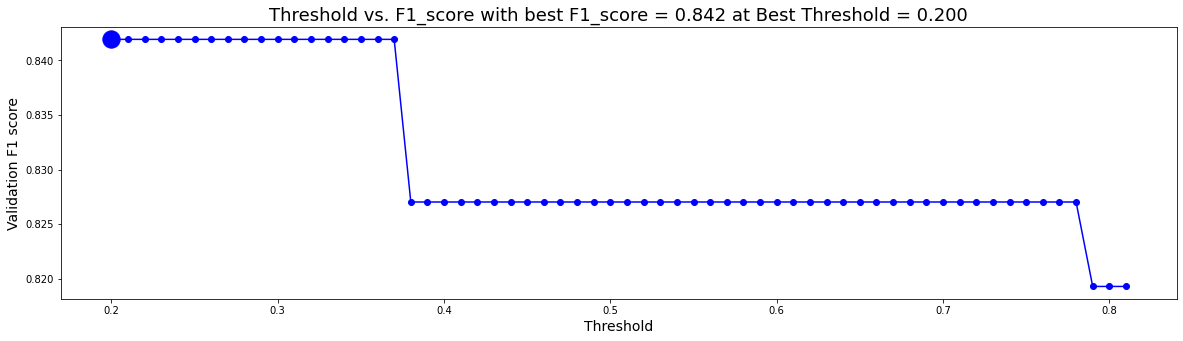

In [1408]:
plot_score(alpha_g_all_thr, alpha_g_scores, alpha_g_threshold, alpha_g_best_score)

In [1409]:
# best_threshold

In [1410]:

# exclude_cols = ['id','ej', 'alpha', 'beta', 'gamma', 'delta', 'epsilon', 'class'
#                 , 'alpha_a', 'alpha_b', 'alpha_d','alpha_g', 'gamma_a', 'gamma_b', 'gamma_e', 'gamma_h', 'is_unknown']
# FEATURES = [c for c in merge_df.columns if c not in exclude_cols]
# df_tr = merge_df[FEATURES] 
# df_tr_label = merge_df[['class']]
# merge_df.head()
# FINAL_FEATURES = ['alpha_a_flag', 'gamma_a_flag', 'gamma_b_flag', 'gamma_e_flag', 'gamma_h_flag', 'gamma_flag']
# FINAL_FEATURES = ['alpha_a_flag', 'gamma_a_flag', 'gamma_b_flag', 'gamma_e_flag', 'gamma_h_flag']
# FINAL_FEATURES = ['alpha_a_flag', 'gamma_a_flag', 'gamma_b_flag', 'gamma_e_flag', 'gamma_h_flag', 'unknown_flag']
# FINAL_FEATURES = ['alpha_a_flag', 'gamma_a_flag', 'gamma_b_flag', 'gamma_e_flag', 'gamma_h_flag', 'unknown_flag', 'gamma_m_flag', 'gamma_n_flag'
#                   , 'beta_c_flag', 'delta_b_flag', 'year_2020_flag']
# FINAL_FEATURES = ['alpha_a_flag', 'gamma_a_flag', 'gamma_b_flag', 'gamma_e_flag', 'gamma_h_flag', 'gamma_m_flag', 'gamma_n_flag']
# FINAL_FEATURES = ['alpha_a_flag', 'gamma_flag']
# FINAL_FEATURES = ['alpha_a_flag', 'unknown_flag', 'gamma_m_flag', 'gamma_n_flag']
# FINAL_FEATURES = ['alpha_a_flag', 'gamma_m_flag', 'gamma_n_flag']
FINAL_FEATURES = ['alpha_a_flag', 'alpha_b_flag', 'alpha_d_flag', 'alpha_g_flag', 'gamma_a_flag', 'gamma_b_flag', 'gamma_e_flag', 'gamma_h_flag', 'gamma_m_flag', 'gamma_n_flag']

In [1411]:
ALL_IDS = merge_df.id.unique()
oof = pd.DataFrame(data=np.zeros((len(ALL_IDS), 2)), index=ALL_IDS, columns=['class_0', 'class_1'])

In [1412]:
merge_df.shape

(617, 88)

In [1413]:
oof = predict_feature(model, 'class', merge_df, oof, FINAL_FEATURES)


-------------------------
--- Fold 1
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 2
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-------------------------
--- Fold 3
-------------------------
[LightGBM] [Warning] Unknown parameter: learning
-------------------------
--- Fold 4
-------------------------


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: learning
-------------------------
--- Fold 5
-------------------------
[LightGBM] [Warning] Unknown parameter: learning


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [1414]:
oof.head()

,class_0,class_1
000ff2bfdfe9,0.099592,0.900408
007255e47698,0.979751,0.020249
013f2bd269f5,0.985682,0.014318
043ac50845d5,0.620072,0.379928
044fb8a146ec,0.732581,0.267419


In [1415]:
from sklearn.metrics import log_loss
def balanced_log_loss(y_true, y_pred):
    nc = np.bincount(y_true)
    return log_loss(y_true, y_pred, sample_weight=1/nc[y_true], eps=1e-15)

In [1416]:
y_true = merge_df['class']
y_pred = oof['class_1']
balanced_log_loss(y_true, y_pred)
# Best score is 0.434939521321878
# 0.423546473626771 with unknown_threshold
# 0.34339783347935104 with gamma m & n
# now is 6.823326702712194e-06?

0.36446104770887644

In [1115]:
y_true = merge_df['class']
y_pred = [0.5]*len(y_true)
balanced_log_loss(y_true, y_pred)

0.6931471805599453

In [1068]:
type(np.array([0]*617))

numpy.ndarray

In [1082]:
np.log(1e-15)

-34.538776394910684

1e-15